In [1]:
import numpy as np
import cupy as cp
import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload

import poppy

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

from prop_models import coro, agpm
reload(coro)

from wfsc import efc_1dm as efc
from wfsc import utils

import misc_funs as misc
wavelength_c = 750e-9*u.m

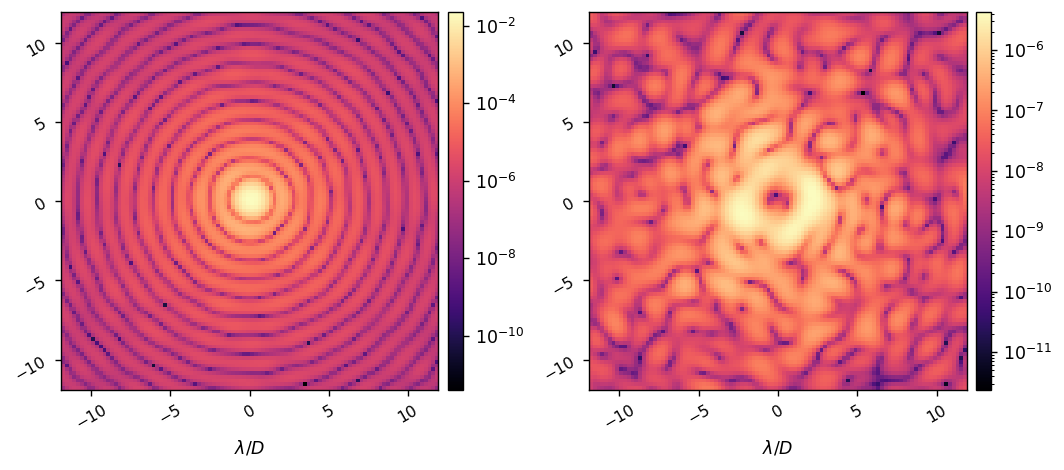

In [2]:
reload(coro)
reload(misc)

vortex = agpm.IdealAGPM(name='VVC', wavelength=wavelength_c, charge=6, singularity=20*u.um)
lyot_stop = poppy.CircularAperture(name='Lyot Stop', radius=3*u.mm, gray_pixel=False)

c = coro.CORO(dm_inf='inf.fits',
              npix=128,
              oversample=16,
              npsf=100,
              use_opds=True,
              LYOT=lyot_stop
             )

c.FPM = None
im_unocc = c.snap()

c.FPM = vortex
ref_im = c.snap()

misc.imshow2(im_unocc, ref_im, 
             lognorm1=True, lognorm2=True,
             pxscl=c.psf_pixelscale_lamD, xlabel='$\lambda/D$')

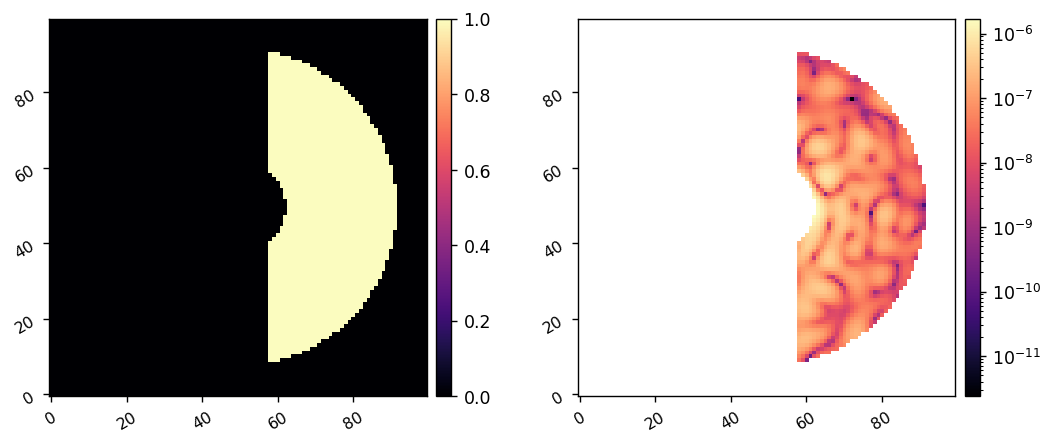

In [3]:
reload(utils)
npsf = c.npsf
nact = c.Nact

xfp = (np.linspace(-npsf/2, npsf/2-1, npsf) + 1/2)*c.psf_pixelscale_lamD
fpx,fpy = np.meshgrid(xfp,xfp)

edge = 2
iwa = 3
owa = 10
rot = 0

# Create the mask that is used to select which region to make dark.
dark_params = {
    'inner_radius' : iwa,
    'outer_radius' : owa,
    'edge_position' : edge,
    'direction' : '+x',
    'rotation':rot,
    'full': False
}
dark_mask = utils.create_annular_focal_plane_mask(fpx, fpy, dark_params)
misc.imshow2(dark_mask, dark_mask*ref_im, lognorm2=True)

In [10]:
dark_mask.sum()

2042

In [11]:
reload(efc)

epsilon = 1e-9 # poke amplitudes (DM surface)
jac = efc.build_jacobian(c, epsilon, dark_mask.flatten(), display=False)

Building Jacobian.
	Calculated response for mode 1/952. Elapsed time=1.426 sec.
	Calculated response for mode 2/952. Elapsed time=2.497 sec.
	Calculated response for mode 3/952. Elapsed time=3.567 sec.
	Calculated response for mode 4/952. Elapsed time=4.644 sec.
	Calculated response for mode 5/952. Elapsed time=5.721 sec.
	Calculated response for mode 6/952. Elapsed time=6.872 sec.
	Calculated response for mode 7/952. Elapsed time=7.969 sec.
	Calculated response for mode 8/952. Elapsed time=9.044 sec.
	Calculated response for mode 9/952. Elapsed time=10.114 sec.
	Calculated response for mode 10/952. Elapsed time=11.197 sec.
	Calculated response for mode 11/952. Elapsed time=12.270 sec.
	Calculated response for mode 12/952. Elapsed time=13.344 sec.
	Calculated response for mode 13/952. Elapsed time=14.418 sec.
	Calculated response for mode 14/952. Elapsed time=15.500 sec.
	Calculated response for mode 15/952. Elapsed time=16.669 sec.
	Calculated response for mode 16/952. Elapsed time=17

	Calculated response for mode 130/952. Elapsed time=142.565 sec.
	Calculated response for mode 131/952. Elapsed time=143.661 sec.
	Calculated response for mode 132/952. Elapsed time=144.745 sec.
	Calculated response for mode 133/952. Elapsed time=145.825 sec.
	Calculated response for mode 134/952. Elapsed time=146.908 sec.
	Calculated response for mode 135/952. Elapsed time=147.989 sec.
	Calculated response for mode 136/952. Elapsed time=149.072 sec.
	Calculated response for mode 137/952. Elapsed time=150.153 sec.
	Calculated response for mode 138/952. Elapsed time=151.236 sec.
	Calculated response for mode 139/952. Elapsed time=152.317 sec.
	Calculated response for mode 140/952. Elapsed time=153.398 sec.
	Calculated response for mode 141/952. Elapsed time=154.478 sec.
	Calculated response for mode 142/952. Elapsed time=155.560 sec.
	Calculated response for mode 143/952. Elapsed time=156.640 sec.
	Calculated response for mode 144/952. Elapsed time=157.723 sec.
	Calculated response for 

	Calculated response for mode 257/952. Elapsed time=279.629 sec.
	Calculated response for mode 258/952. Elapsed time=280.708 sec.
	Calculated response for mode 259/952. Elapsed time=281.786 sec.
	Calculated response for mode 260/952. Elapsed time=282.863 sec.
	Calculated response for mode 261/952. Elapsed time=283.940 sec.
	Calculated response for mode 262/952. Elapsed time=285.013 sec.
	Calculated response for mode 263/952. Elapsed time=286.088 sec.
	Calculated response for mode 264/952. Elapsed time=287.169 sec.
	Calculated response for mode 265/952. Elapsed time=288.243 sec.
	Calculated response for mode 266/952. Elapsed time=289.319 sec.
	Calculated response for mode 267/952. Elapsed time=290.399 sec.
	Calculated response for mode 268/952. Elapsed time=291.495 sec.
	Calculated response for mode 269/952. Elapsed time=292.575 sec.
	Calculated response for mode 270/952. Elapsed time=293.673 sec.
	Calculated response for mode 271/952. Elapsed time=294.751 sec.
	Calculated response for 

	Calculated response for mode 384/952. Elapsed time=417.571 sec.
	Calculated response for mode 385/952. Elapsed time=418.646 sec.
	Calculated response for mode 386/952. Elapsed time=419.721 sec.
	Calculated response for mode 387/952. Elapsed time=420.806 sec.
	Calculated response for mode 388/952. Elapsed time=421.884 sec.
	Calculated response for mode 389/952. Elapsed time=422.967 sec.
	Calculated response for mode 390/952. Elapsed time=424.044 sec.
	Calculated response for mode 391/952. Elapsed time=425.128 sec.
	Calculated response for mode 392/952. Elapsed time=426.207 sec.
	Calculated response for mode 393/952. Elapsed time=427.284 sec.
	Calculated response for mode 394/952. Elapsed time=428.361 sec.
	Calculated response for mode 395/952. Elapsed time=429.460 sec.
	Calculated response for mode 396/952. Elapsed time=430.544 sec.
	Calculated response for mode 397/952. Elapsed time=431.648 sec.
	Calculated response for mode 398/952. Elapsed time=432.724 sec.
	Calculated response for 

	Calculated response for mode 511/952. Elapsed time=554.637 sec.
	Calculated response for mode 512/952. Elapsed time=555.711 sec.
	Calculated response for mode 513/952. Elapsed time=556.787 sec.
	Calculated response for mode 514/952. Elapsed time=557.858 sec.
	Calculated response for mode 515/952. Elapsed time=558.934 sec.
	Calculated response for mode 516/952. Elapsed time=560.007 sec.
	Calculated response for mode 517/952. Elapsed time=561.082 sec.
	Calculated response for mode 518/952. Elapsed time=562.159 sec.
	Calculated response for mode 519/952. Elapsed time=563.240 sec.
	Calculated response for mode 520/952. Elapsed time=564.316 sec.
	Calculated response for mode 521/952. Elapsed time=565.396 sec.
	Calculated response for mode 522/952. Elapsed time=566.474 sec.
	Calculated response for mode 523/952. Elapsed time=567.555 sec.
	Calculated response for mode 524/952. Elapsed time=568.630 sec.
	Calculated response for mode 525/952. Elapsed time=569.707 sec.
	Calculated response for 

	Calculated response for mode 638/952. Elapsed time=692.330 sec.
	Calculated response for mode 639/952. Elapsed time=693.427 sec.
	Calculated response for mode 640/952. Elapsed time=694.540 sec.
	Calculated response for mode 641/952. Elapsed time=695.638 sec.
	Calculated response for mode 642/952. Elapsed time=696.748 sec.
	Calculated response for mode 643/952. Elapsed time=697.822 sec.
	Calculated response for mode 644/952. Elapsed time=698.901 sec.
	Calculated response for mode 645/952. Elapsed time=699.975 sec.
	Calculated response for mode 646/952. Elapsed time=701.055 sec.
	Calculated response for mode 647/952. Elapsed time=702.146 sec.
	Calculated response for mode 648/952. Elapsed time=703.236 sec.
	Calculated response for mode 649/952. Elapsed time=704.321 sec.
	Calculated response for mode 650/952. Elapsed time=705.403 sec.
	Calculated response for mode 651/952. Elapsed time=706.477 sec.
	Calculated response for mode 652/952. Elapsed time=707.555 sec.
	Calculated response for 

	Calculated response for mode 765/952. Elapsed time=829.619 sec.
	Calculated response for mode 766/952. Elapsed time=830.696 sec.
	Calculated response for mode 767/952. Elapsed time=831.773 sec.
	Calculated response for mode 768/952. Elapsed time=832.851 sec.
	Calculated response for mode 769/952. Elapsed time=833.929 sec.
	Calculated response for mode 770/952. Elapsed time=835.011 sec.
	Calculated response for mode 771/952. Elapsed time=836.084 sec.
	Calculated response for mode 772/952. Elapsed time=837.162 sec.
	Calculated response for mode 773/952. Elapsed time=838.244 sec.
	Calculated response for mode 774/952. Elapsed time=839.328 sec.
	Calculated response for mode 775/952. Elapsed time=840.408 sec.
	Calculated response for mode 776/952. Elapsed time=841.485 sec.
	Calculated response for mode 777/952. Elapsed time=842.563 sec.
	Calculated response for mode 778/952. Elapsed time=843.635 sec.
	Calculated response for mode 779/952. Elapsed time=844.711 sec.
	Calculated response for 

	Calculated response for mode 892/952. Elapsed time=966.887 sec.
	Calculated response for mode 893/952. Elapsed time=967.985 sec.
	Calculated response for mode 894/952. Elapsed time=969.066 sec.
	Calculated response for mode 895/952. Elapsed time=970.203 sec.
	Calculated response for mode 896/952. Elapsed time=971.281 sec.
	Calculated response for mode 897/952. Elapsed time=972.407 sec.
	Calculated response for mode 898/952. Elapsed time=973.500 sec.
	Calculated response for mode 899/952. Elapsed time=974.576 sec.
	Calculated response for mode 900/952. Elapsed time=975.657 sec.
	Calculated response for mode 901/952. Elapsed time=976.736 sec.
	Calculated response for mode 902/952. Elapsed time=977.814 sec.
	Calculated response for mode 903/952. Elapsed time=978.896 sec.
	Calculated response for mode 904/952. Elapsed time=979.971 sec.
	Calculated response for mode 905/952. Elapsed time=981.047 sec.
	Calculated response for mode 906/952. Elapsed time=982.126 sec.
	Calculated response for 

In [12]:
misc.save_fits('jacobians\jacobian_20230307.fits', jac, header={'NACTS':952, 'NMASK':2042})

Saved data to:  jacobian_20230307.fits


In [4]:
jac = fits.getdata('jacobians\jacobian_20230307.fits')


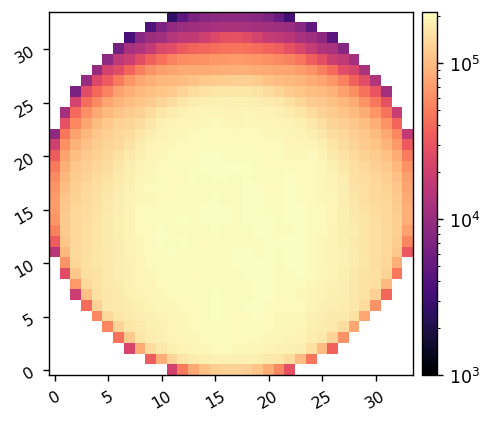

In [5]:
reload(utils)
response = utils.map_acts_to_dm(np.sqrt(((jac)**2).sum(axis=0)), c.dm_mask)
misc.imshow1(response, lognorm=True, vmin=1e3)

In [7]:
reload(utils)
reg_fun = utils.beta_reg
reg_conds = np.array([[0, 20, 25, 35, 40],
                      [-2, -4, -2, -3, -2]])

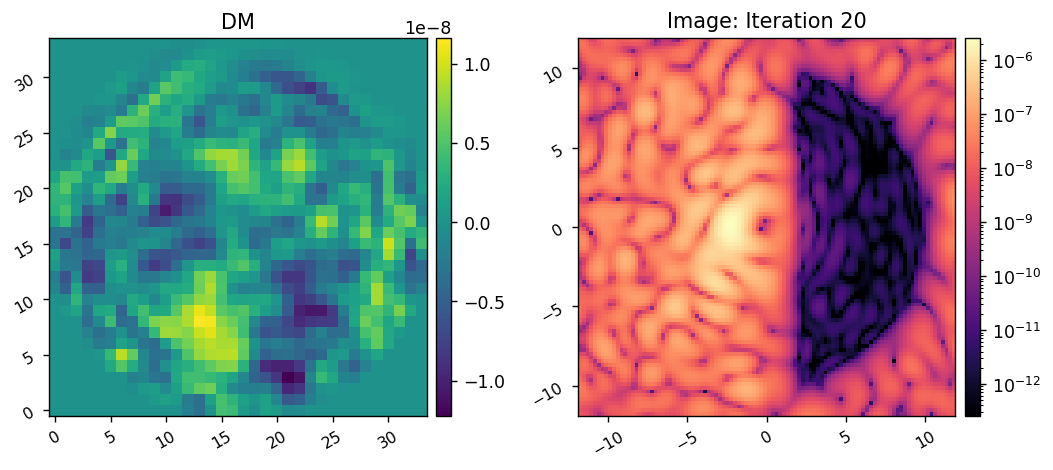

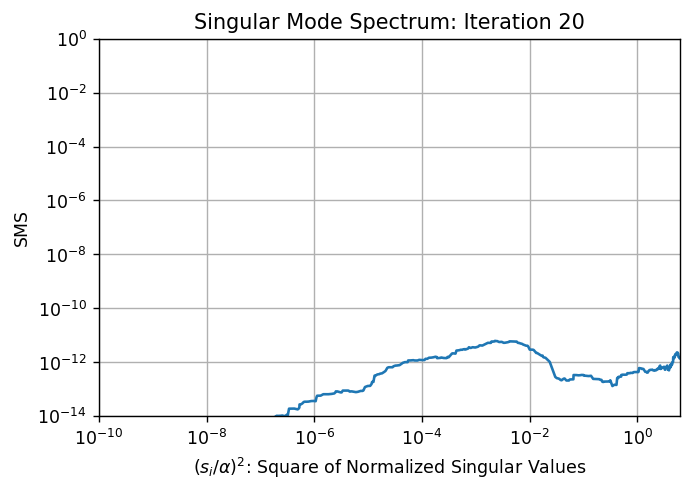

EFC completed in 24.798 sec.


In [8]:
reload(efc)
reload(utils)
c.reset_dm()
commands1, efields1 = efc.run_efc_perfect(c,
                                         jac,
                                         reg_fun,
                                         reg_conds,
                                         dark_mask, 
                                         im_unocc.max(),
                                         iterations=20, 
                                         display_current=True, 
#                                           display_all=True,
                                         plot_sms=True)